In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from tensorflow import keras as k
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tscv import GapKFold
import keras_tuner as kt

Import the datasets with: hourly prices for close, high, low and normalized (dividing by the exchange supply) exchange in and out-flows 

In [2]:
#import data
btc_data = pd.read_csv(r'data\btc_daily_data_NET_normflows.csv')
btc_data.index = btc_data['date']
btc_data = btc_data.drop(['date', 'Unnamed: 0'], 1)
eth_data = pd.read_csv(r'data\eth_daily_data_NET_normflows.csv')
eth_data.index = eth_data['date']
eth_data = eth_data.drop(['date', 'Unnamed: 0'], 1)

btc_data.head()

,binance.NET,bitfinex.NET,bitmex.NET,bitstamp.NET,bittrex.NET,gemini.NET,huobi.NET,kraken.NET,poloniex.NET,close,high,low,high-low,volume
date,,,,,,,,,,,,,,
2016-06-30,0.0,-0.012270,0.017409,-0.016702,-0.009903,0.005842,-0.015312,0.014851,-0.030453,670.02,673.04,631.24,41.80,148920.0
2016-07-01,0.0,0.024632,0.015962,0.007998,0.013063,-0.003012,-0.014840,-0.006862,0.006676,674.57,685.11,661.09,24.02,100240.0
2016-07-02,0.0,-0.022647,-0.004396,-0.003835,0.000736,-0.001264,-0.063752,0.004943,-0.011848,698.06,700.46,671.46,29.00,177630.0
2016-07-03,0.0,0.030178,-0.000445,0.004135,0.006834,0.011327,-0.071043,-0.003073,0.000263,661.64,701.49,644.61,56.88,65100.0
2016-07-04,0.0,0.001660,-0.003988,0.003470,0.011064,0.005198,0.024649,0.022781,0.007431,675.16,679.03,644.04,34.99,67140.0


In [3]:

def split_dataset(dataset, prices, n_steps, train_percentage=0.8, input_scaler=None, output_scaler=None):
	## 'dataset' and 'prices' are arrays
	# Splits a multivariate dataset ('dataset') into samples of size 'n_steps', 
	# flattens the resulting input samples and associates the corresponding output from 'prices',
	# divides the dataset in train and test data using 'train_percentage',
	# if 'input_scaler' and 'output_scaler' are not None: 
	# scales the resulting train and test data base on the train data statistics
	
	X, y = list(), list()
	for i in range(len(dataset)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix >= len(dataset):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = dataset[i:end_ix, :], prices[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	
	X, y = np.array(X), np.array(y)
	# flatten input
	n_input = X.shape[1] * X.shape[2]
	X = X.reshape((X.shape[0], n_input))
	#divide in train and test data
	n = X.shape[0]
	ix = int(n*train_percentage)
	X_train = X[:ix, :]
	X_test = X[ix:, :]
	y_train = y[:ix]
	y_test = y[ix:]

	## scale inputs
	if input_scaler is not None:
		input_scaler.fit(X_train)
		X_train = input_scaler.transform(X_train)
		X_test = input_scaler.transform(X_test)
    ## scale outputs
	if output_scaler is not None:
        # reshape 1d arrays to 2d arrays
		y_train = y_train.reshape(len(y_train), 1)
		y_test = y_test.reshape(len(y_test), 1)
		output_scaler.fit(y_train)
		y_train = output_scaler.transform(y_train)
		y_test = output_scaler.transform(y_test)
	
	return X_train, X_test, y_train, y_test


BITCOIN

PRICE REGRESSION

Linear regression (Benchmark model):

In [357]:
n_steps = 2

## NO NORMALIZATION ##
#split dataset
X_train, X_test, y_train, y_test = split_dataset(btc_data.values, btc_data['close'], n_steps)

#Linear regression (Benchmark model)
reg = LinearRegression().fit(X_train, y_train)
yhat = reg.predict(X_test)
mse = np.power(y_test-yhat, 2).sum() / len(y_test)

print(r'No normalization, {} time steps: MSE = {}'.format(n_steps, mse))

## MIN-MAX NORMALIZATION ##
#normalize and split data
X_train, X_test, y_train, y_test = split_dataset(btc_data.values, btc_data['close'], n_steps, input_scaler=MinMaxScaler(), output_scaler=MinMaxScaler())

#Linear regression (Benchmark model)
reg = LinearRegression().fit(X_train, y_train)
yhat = reg.predict(X_test)
mse = np.power(y_test-yhat, 2).sum() / len(y_test)

print(r'Min-Max normalization, {} time steps: MSE = {}'.format(n_steps, mse))

## MEAN NORMALIZATION ##
#normalize and split data
X_train, X_test, y_train, y_test = split_dataset(btc_data.values, btc_data['close'], n_steps, input_scaler=StandardScaler(), output_scaler=StandardScaler())
#Linear regression (Benchmark model)
reg = LinearRegression().fit(X_train, y_train)
yhat = reg.predict(X_test)
mse = np.power(y_test-yhat, 2).sum() / len(y_test)

print(r'Mean normalization, {} time steps: MSE = {}'.format(n_steps, mse))


No normalization, 2 time steps: MSE = 2438746.5665070675
Min-Max normalization, 2 time steps: MSE = 0.00687639961005032
Mean normalization, 2 time steps: MSE = 0.17777034721913973


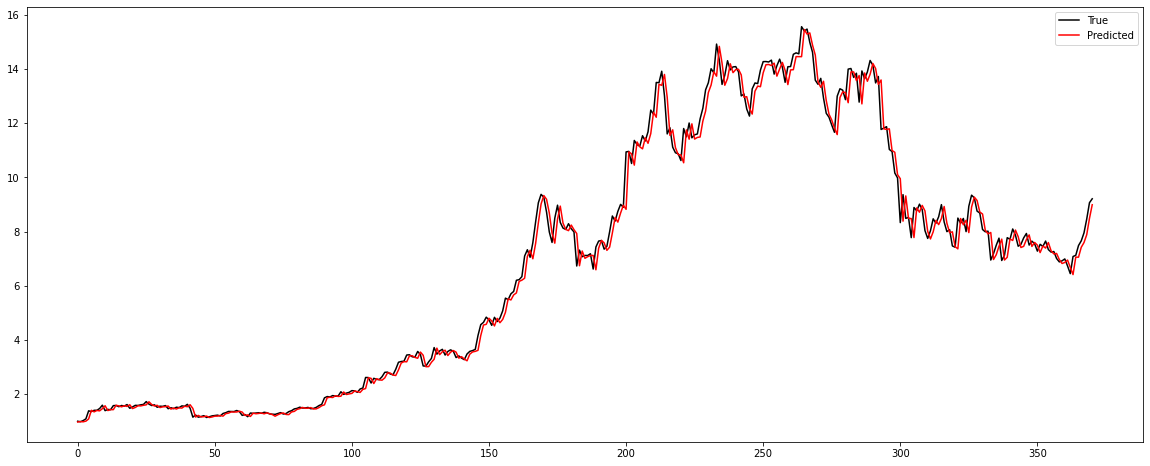

In [358]:
n_steps = 2
#split dataset
X_train, X_test, y_train, y_test = split_dataset(btc_data.values, btc_data['close'], n_steps, input_scaler=StandardScaler(), output_scaler=StandardScaler())

#Linear regression (Benchmark model)
reg = LinearRegression().fit(X_train, y_train)
yhat = reg.predict(X_test)
plt.figure(figsize=(20,8))
plt.plot(y_test, color='black', label='True')
plt.plot(yhat, color = 'red', label='Predicted')
plt.legend()
plt.show()

In [359]:
#Using the previous price as price predictor (Mean normalization)
mse = np.power(y_test[1:]-y_test[:-1], 2).sum() / (len(y_test)-1)
print('Using previous price: MSE = ', mse)

Using previous price: MSE =  0.1760848028329517


In [360]:
## MLP Hyper-parameter tuning ##
def build_model(hp):
    model = k.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=526, step=32), 
                activity_regularizer=k.regularizers.l2(hp.Float(f'l2_{i}', min_value=0.001, max_value=0.1, sampling='log'))
            )
        )
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

    model.add(layers.Dense(1, activation="linear"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), 
        loss='mse',
        metrics=['mean_squared_error']
    )
    return model


#create hp tuner which applies cross-validation
class CVTuner(kt.engine.tuner.Tuner):
  def run_trial(self, trial, x, y, batch_size=50, epochs=1, n_steps=1):
    #optimize number of steps
    cv = GapKFold(n_splits=5, gap_before=n_steps-1, gap_after=n_steps-1)
    val_losses = []
    for train_indices, val_indices in cv.split(x):
      x_train, x_val = x[train_indices], x[val_indices]
      y_train, y_val = y[train_indices], y[val_indices]
      model = self.hypermodel.build(trial.hyperparameters)
      model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
      val_losses.append(model.evaluate(x_val, y_val))
    self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})
    #self.save_model(trial.trial_id, model)

tuner = CVTuner(
  hypermodel=build_model,
  oracle=kt.oracles.BayesianOptimization(
    objective='val_loss',
    max_trials=100),
  overwrite=True,
  directory='MLP_price_daily',
  project_name='MLP_price_daily_training')

n_steps=2
X_cv, X_test, y_cv, y_test = split_dataset(btc_data.values, btc_data['close'], n_steps, input_scaler=StandardScaler(), output_scaler=StandardScaler())
tuner.search(X_cv, y_cv, batch_size=50, epochs=30, n_steps=n_steps)

Trial 50 Complete [00h 00m 14s]
val_loss: 0.07688834378495812

Best val_loss So Far: 0.0404481247998774
Total elapsed time: 00h 13m 05s
INFO:tensorflow:Oracle triggered exit


In [361]:
tuner.results_summary()

Results summary
Results in MLP_price_daily\MLP_price_daily_training
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_layers: 1
units_0: 16
l2_0: 0.001
lr: 0.01
units_1: 320
l2_1: 0.011273242702608835
units_2: 16
l2_2: 0.1
Score: 0.0404481247998774
Trial summary
Hyperparameters:
num_layers: 1
units_0: 320
l2_0: 0.001
lr: 0.01
units_1: 224
l2_1: 0.037829935643081083
units_2: 16
l2_2: 0.001
Score: 0.0550179734826088
Trial summary
Hyperparameters:
num_layers: 1
units_0: 16
l2_0: 0.001
lr: 0.01
units_1: 304
l2_1: 0.001
units_2: 16
l2_2: 0.001
Score: 0.05757355596870184
Trial summary
Hyperparameters:
num_layers: 1
units_0: 16
l2_0: 0.001
lr: 0.01
units_1: 16
l2_1: 0.001
units_2: 320
l2_2: 0.1
Score: 0.06133822333067655
Trial summary
Hyperparameters:
num_layers: 1
units_0: 176
l2_0: 0.001
lr: 0.01
units_1: 160
l2_1: 0.014854239081224664
units_2: 160
l2_2: 0.010280946518975717
Score: 0.06695640552788973
Trial summary
Hyperparameters:
num_lay

In [362]:
#Best MLP
n_steps = 2

#split data
X_train, X_test, y_train, y_test = split_dataset(btc_data.values, btc_data['close'], n_steps, input_scaler=StandardScaler(), output_scaler=StandardScaler())
#model definition
model = k.Sequential()
model.add(layers.Dense(16, input_dim=X_train.shape[1], activity_regularizer=k.regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.Dense(1, activation="linear"))
learning_rate = 0.01
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='mse',
              metrics=['mean_squared_error']
             )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001, verbose=1)
history = model.fit(X_train, y_train, 
                    epochs = 50, 
                    batch_size = 64,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/50
24/24 [==============================] - 1s 6ms/step - loss: 0.2515 - mean_squared_error: 0.2170 - val_loss: 4.7912 - val_mean_squared_error: 4.2241
Epoch 2/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0997 - mean_squared_error: 0.0612 - val_loss: 4.0270 - val_mean_squared_error: 3.4023
Epoch 3/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0738 - mean_squared_error: 0.0431 - val_loss: 1.0794 - val_mean_squared_error: 0.5183
Epoch 4/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0630 - mean_squared_error: 0.0391 - val_loss: 0.8073 - val_mean_squared_error: 0.2841
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0570 - mean_squared_error: 0.0375 - val_loss: 0.8847 - val_mean_squared_error: 0.3856
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0682 - mean_squared_error: 0.0509 - val_loss: 1.0405 - val_mean_squared_error: 0.5677
Epoch 7/50
24/24 [======================

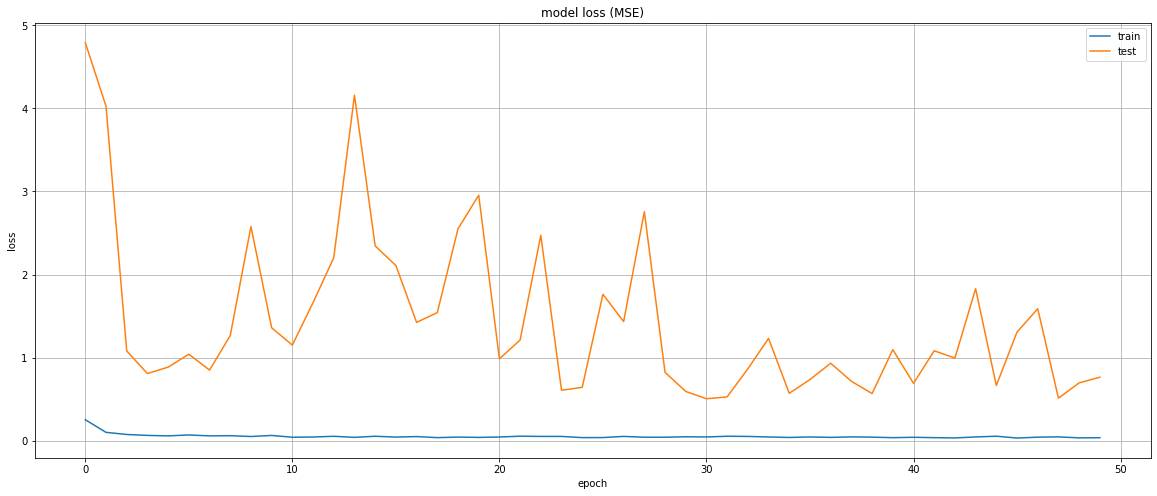

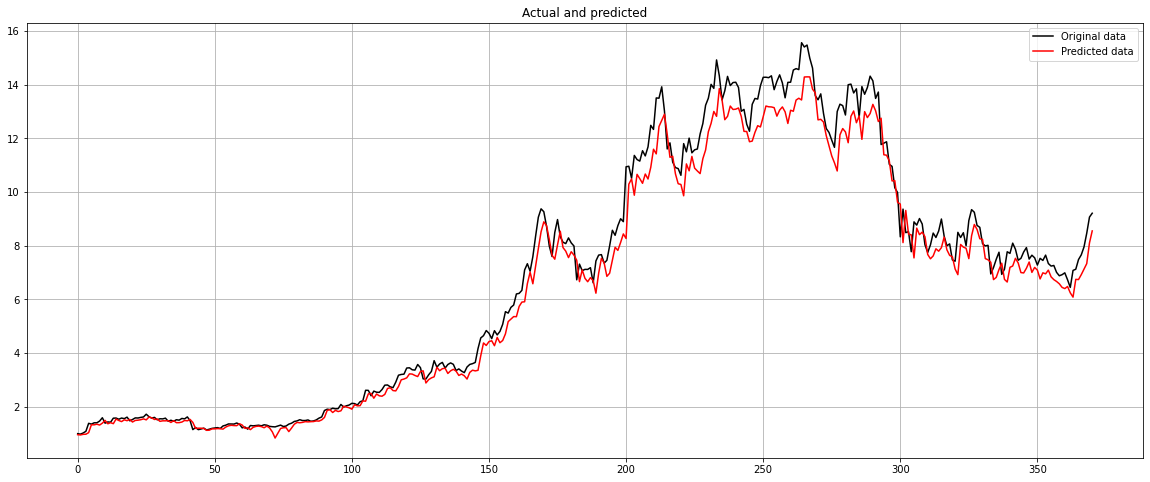

Test MSE =  0.47320374761748785


In [364]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.title('model loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
pred = model.predict(np.array(X_test))
original = y_test
predicted = pred
plt.figure(figsize=(20,8))
plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='red', label = 'Predicted data')
plt.grid(True)
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()
test_mse = np.mean(np.power(y_test-pred, 2))
print('Test MSE = ', test_mse)

RETURNS REGRESSION


In [4]:
#compute returns 
log_ret = np.log(btc_data['close'].values[1:] / btc_data['close'].values[:-1])
log_ret_high = np.log(btc_data['high'].values[1:] / btc_data['close'].values[:-1])
log_ret_low = np.log(btc_data['low'].values[1:] / btc_data['close'].values[:-1])

btc_data_ret = pd.DataFrame(data=btc_data.values[1:, :], columns = btc_data.columns, index=btc_data.index[1:])
btc_data_ret['close'] = log_ret
btc_data_ret['high'] = log_ret_high
btc_data_ret['low'] = log_ret_low


In [5]:
btc_data_ret

,binance.NET,bitfinex.NET,bitmex.NET,bitstamp.NET,bittrex.NET,gemini.NET,huobi.NET,kraken.NET,poloniex.NET,close,high,low,high-low,volume
date,,,,,,,,,,,,,,
2016-07-01,0.000000,0.024632,0.015962,0.007998,0.013063,-0.003012,-0.014840,-0.006862,0.006676,0.006768,0.022272,-0.013418,24.02,100240.0
2016-07-02,0.000000,-0.022647,-0.004396,-0.003835,0.000736,-0.001264,-0.063752,0.004943,-0.011848,0.034230,0.037662,-0.004621,29.00,177630.0
2016-07-03,0.000000,0.030178,-0.000445,0.004135,0.006834,0.011327,-0.071043,-0.003073,0.000263,-0.053583,0.004902,-0.079660,56.88,65100.0
2016-07-04,0.000000,0.001660,-0.003988,0.003470,0.011064,0.005198,0.024649,0.022781,0.007431,0.020228,0.025944,-0.026961,34.99,67140.0
2016-07-05,0.000000,-0.011358,-0.046352,-0.005179,-0.000648,-0.001491,0.030021,-0.003803,0.030980,-0.017165,0.005951,-0.026794,21.88,66150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-24,-0.000504,-0.001567,-0.001019,0.001117,-0.001021,0.000317,-0.000964,-0.004108,0.002328,0.018983,0.025878,-0.006228,1090.66,63910.0
2021-07-25,-0.008142,-0.000872,-0.003887,0.004664,-0.001471,0.001484,-0.011410,-0.005160,0.002814,0.031225,0.031584,-0.011447,1490.27,99270.0
2021-07-26,-0.002849,-0.008270,0.003795,0.004621,-0.012316,0.007896,0.009216,-0.002045,-0.006142,0.052314,0.136769,-0.002822,5283.61,67380.0


In [8]:
for n_steps in range(1, 5):

    ## NO NORMALIZATION ##
    #split dataset
    X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8)

    #Linear regression (Benchmark model)
    reg = LinearRegression().fit(X_train, y_train)
    yhat = reg.predict(X_test)
    mse = np.power(y_test-yhat, 2).sum() / len(y_test)

    print(r'No normalization, {} time steps: MSE = {}'.format(n_steps, mse))

    ## MIN-MAX NORMALIZATION ##
    #normalize and split data
    X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=MinMaxScaler(), output_scaler=MinMaxScaler())

    #Linear regression (Benchmark model)
    reg = LinearRegression().fit(X_train, y_train)
    yhat = reg.predict(X_test)
    mse = np.power(y_test-yhat, 2).sum() / len(y_test)

    print(r'Min-Max normalization, {} time steps: MSE = {}'.format(n_steps, mse))

    ## MEAN NORMALIZATION ##
    #normalize and split data
    X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())

    #Linear regression (Benchmark model)
    reg = LinearRegression().fit(X_train, y_train)
    yhat = reg.predict(X_test)
    mse = np.power(y_test-yhat, 2).sum() / len(y_test)

    print(r'Mean normalization, {} time steps: MSE = {}'.format(n_steps, mse)+'\n')


No normalization, 1 time steps: MSE = 0.0018312270367647
Min-Max normalization, 1 time steps: MSE = 0.003657844432416432
Mean normalization, 1 time steps: MSE = 1.020596354825218

No normalization, 2 time steps: MSE = 0.0020330075099258362
Min-Max normalization, 2 time steps: MSE = 0.004060897448178326
Mean normalization, 2 time steps: MSE = 1.13273861671116

No normalization, 3 time steps: MSE = 0.0021110343535006093
Min-Max normalization, 3 time steps: MSE = 0.004216754723285377
Mean normalization, 3 time steps: MSE = 1.176776123234503

No normalization, 4 time steps: MSE = 0.0021422969899781976
Min-Max normalization, 4 time steps: MSE = 0.004279201299580247
Mean normalization, 4 time steps: MSE = 1.1943378687656632



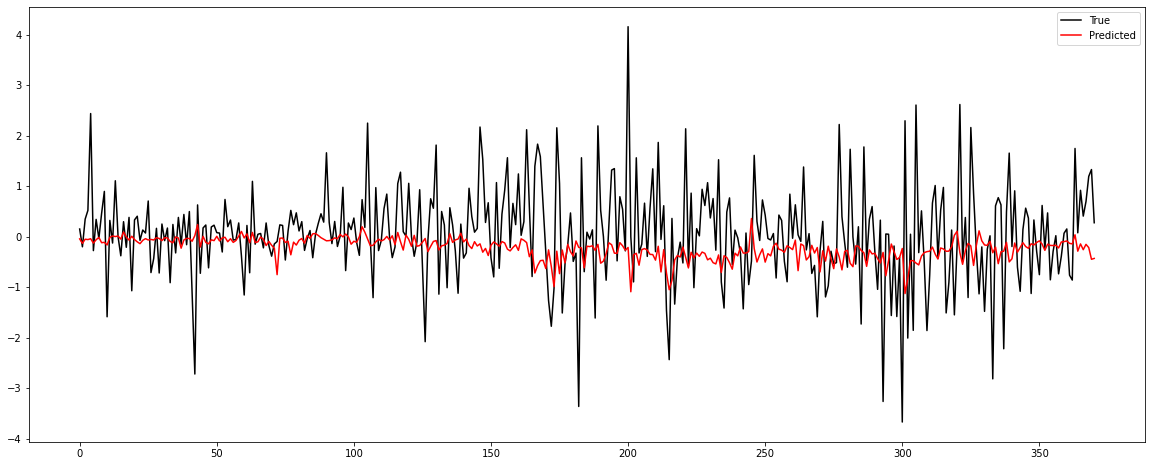

In [14]:
n_steps = 1
#split dataset
X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())

#Linear regression (Benchmark model)
reg = LinearRegression().fit(X_train, y_train)
yhat = reg.predict(X_test)
plt.figure(figsize=(20,8))
plt.plot(y_test, color='black', label='True')
plt.plot(yhat, color = 'red', label='Predicted')
plt.legend()
plt.show()

In [10]:
#Using the previous return as return predictor (No normalization)
X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps)
mse = np.power(y_test[1:]-y_test[:-1], 2).sum() / (len(y_test)-1)
print('Using previous return: MSE = ', mse)

Using previous return: MSE =  0.0035413902642893046


In [442]:
## MLP Hyper-parameter tuning ##
def build_model(hp):
    model = k.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(1):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int('units', min_value=16, max_value=320, step=16), 
                activity_regularizer=k.regularizers.l2(0.9)
            )
        )
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation="linear"))
    learning_rate = 0.005
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), 
        loss='mse',
        metrics=['mean_squared_error']
    )
    return model


#create hp tuner which applies cross-validation
class CVTuner(kt.engine.tuner.Tuner):
  def run_trial(self, trial, x, y, batch_size=50, epochs=1, n_steps=1):
    #optimize number of steps
    cv = GapKFold(n_splits=5, gap_before=n_steps-1, gap_after=n_steps-1)
    val_losses = []
    for train_indices, val_indices in cv.split(x):
      x_train, x_val = x[train_indices], x[val_indices]
      y_train, y_val = y[train_indices], y[val_indices]
      model = self.hypermodel.build(trial.hyperparameters)
      model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
      val_losses.append(model.evaluate(x_val, y_val))
    self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})
    #self.save_model(trial.trial_id, model)

tuner = CVTuner(
  hypermodel=build_model,
  oracle=kt.oracles.RandomSearch(
    objective='val_loss',
    max_trials=30),
  overwrite=True,
  directory='MLP_ret_daily',
  project_name='MLP_ret_daily_training')

n_steps=2
X_cv, X_test, y_cv, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.9, input_scaler=StandardScaler(), output_scaler=StandardScaler())
tuner.search(X_cv, y_cv, batch_size=64, epochs=30, n_steps=n_steps)

Trial 13 Complete [00h 00m 12s]
val_loss: 1.1831583380699158

Best val_loss So Far: 1.1314291298389434
Total elapsed time: 00h 03m 03s
INFO:tensorflow:Oracle triggered exit


In [443]:
tuner.results_summary()

Results summary
Results in MLP_ret_daily\MLP_ret_daily_training
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 192
Score: 1.1314291298389434
Trial summary
Hyperparameters:
units: 144
Score: 1.1438583314418793
Trial summary
Hyperparameters:
units: 64
Score: 1.1522231698036194
Trial summary
Hyperparameters:
units: 96
Score: 1.1537715673446656
Trial summary
Hyperparameters:
units: 128
Score: 1.1597370147705077
Trial summary
Hyperparameters:
units: 112
Score: 1.1675290942192078
Trial summary
Hyperparameters:
units: 160
Score: 1.1754132330417633
Trial summary
Hyperparameters:
units: 80
Score: 1.1831583380699158
Trial summary
Hyperparameters:
units: 304
Score: 1.1987541377544404
Trial summary
Hyperparameters:
units: 288
Score: 1.2277720987796783


In [25]:
#Best MLP

def build_and_fit_model(n_steps, btc_data_ret):
    #split data
    X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())

    #model definition
    model = k.Sequential()
    initializer = k.initializers.GlorotNormal()
    model.add(layers.Dense(140, input_dim=X_train.shape[1], activity_regularizer=k.regularizers.l1(0.8), kernel_initializer=initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation="linear"))
    learning_rate = 0.001
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                loss='mse',
                metrics=['mean_squared_error']
                )
    #define callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001, verbose=1)
    early_stop = EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=20,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
    )
    #fit model
    history = model.fit(X_train, y_train, 
                        epochs = 100, 
                        batch_size = 50, 
                        verbose=1,
                        shuffle=False,
                        validation_data=(X_test, y_test))
    return history, model, X_test, y_test

In [26]:
def plot_results(n_steps, model, history, X_test, y_test):
    print('-> N_STEPS = ', n_steps)
    plt.figure(figsize=(20,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid(True)
    plt.title('model loss (MSE)')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    pred = model.predict(np.array(X_test))
    original = y_test
    predicted = pred
    plt.figure(figsize=(20,8))
    plt.plot(original, color='black', label = 'Original data')
    plt.plot(predicted, color='red', label = 'Predicted data')
    plt.grid(True)
    plt.legend(loc='best')
    plt.title('Actual and predicted')
    plt.show()
    test_mse = np.mean(np.power(y_test-pred, 2))
    print('Test MSE = ', test_mse)

Epoch 1/100
30/30 [==============================] - 1s 6ms/step - loss: 41.1761 - mean_squared_error: 1.9929 - val_loss: 62.5544 - val_mean_squared_error: 1.1070
Epoch 2/100
30/30 [==============================] - 0s 2ms/step - loss: 34.6787 - mean_squared_error: 1.3508 - val_loss: 54.5405 - val_mean_squared_error: 1.0739
Epoch 3/100
30/30 [==============================] - 0s 2ms/step - loss: 29.3345 - mean_squared_error: 1.2926 - val_loss: 47.1525 - val_mean_squared_error: 1.0447
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 24.6115 - mean_squared_error: 1.3062 - val_loss: 40.5859 - val_mean_squared_error: 1.1189
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 20.3947 - mean_squared_error: 1.2545 - val_loss: 34.4780 - val_mean_squared_error: 1.0517
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 16.6130 - mean_squared_error: 1.1406 - val_loss: 29.1170 - val_mean_squared_error: 1.0736
Epoch 7/100
30/30 [===

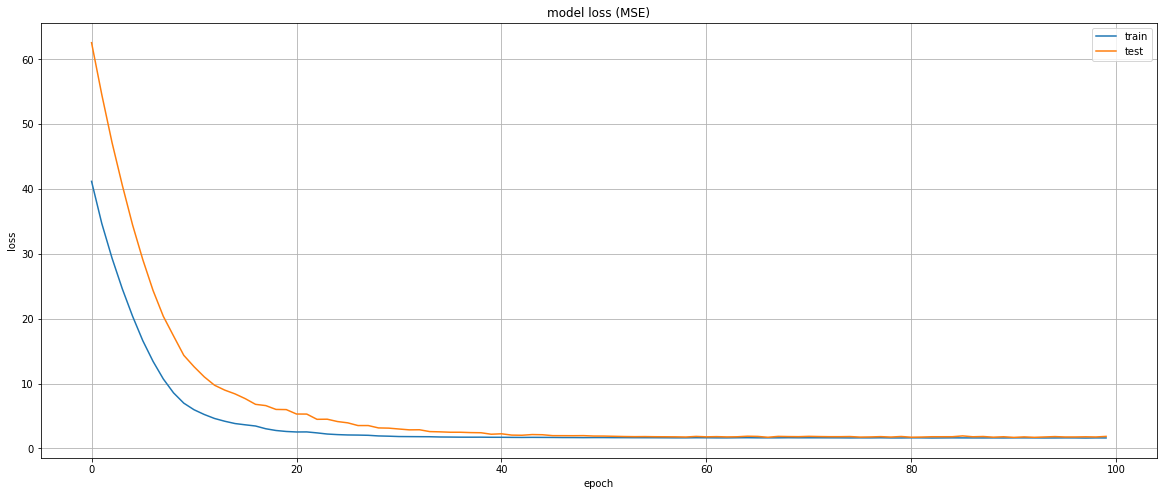

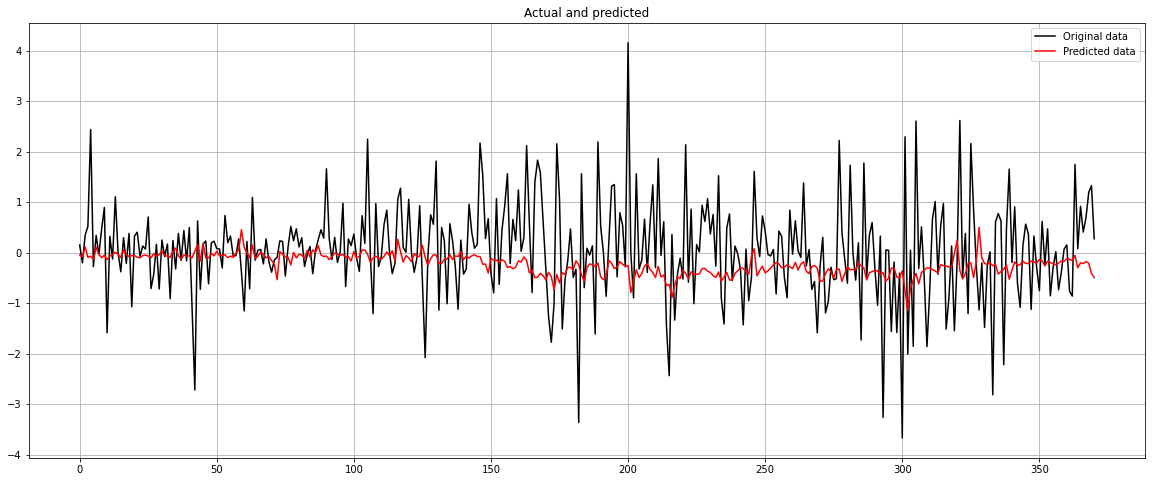

Test MSE =  0.99966699596691


In [27]:
n_steps = 2
history, model, X_test, y_test = build_and_fit_model(n_steps, btc_data_ret)
plot_results(n_steps, model, history, X_test, y_test)